# Projet 5 - Catégorisez automatiquement des questions - Notebook Exploratoire

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.corpus import words as nltk_words
from pandarallel import pandarallel
from wordcloud import WordCloud 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import wordninja
from nltk import pos_tag
from sklearn.model_selection import train_test_split
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
#import tensorflow as tf
#import tensorflow.keras
#from tensorflow.keras import backend as K

#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras import metrics as kmetrics
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import Model

# Bert
#import os
#import transformers
#from transformers import *

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download("words")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\doare\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Fonction 

In [3]:
def info_tokens(tokens):
    """Afficher des infos sur le corpus """
    print(f"Nombre de tokens : {len(tokens)} et nombre de tokens uniques {len(set(tokens))}")
    print(tokens[:30])

## Importation du jeu de données et Nettoyage de nos différents corpus

Requete pour récupérer le jeu de données :
<br>SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount
<br>FROM Posts
<br>WHERE PostTypeId = 1 AND ViewCount > 10 AND Score >= 3 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

In [4]:
df = pd.read_csv('dataset.csv')

In [5]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount
0,What's a good html e-mail template system that...,<p>We have a web application that periodically...,<java><html><text><templates><email>,468478,4,2351
1,Rows With Different UI Swift and also reusing ...,<p>I am making a layout similar to this <a hre...,<ios><swift><uitableview><storyboard><xib>,39000110,3,331
2,How can I set the colors per value when colori...,"<p>In matplotlib (in particular, pandas), how ...",<python><pandas><matplotlib><colors><seaborn>,39000115,5,5654
3,R: How can I read a CSV file with data.table::...,<p>I got several CSV files which contain numbe...,<r><data.table><fread><read.csv><readr>,39000131,7,7510
4,Run bash script with sh,<p>I have bash script and it requires bash.</p...,<linux><bash><shell><sh><dash-shell>,19538669,18,89968


In [6]:
df.describe()

,Id,Score,ViewCount
count,5.000000e+04,50000.000000,5.000000e+04
mean,2.699523e+07,17.869860,1.695824e+04
std,1.946947e+07,127.205325,9.207491e+04
min,4.000000e+00,3.000000,1.800000e+01
25%,1.091972e+07,3.000000,1.270000e+03
50%,2.265128e+07,5.000000,3.393500e+03
75%,4.087011e+07,9.000000,9.864000e+03
max,7.413322e+07,7621.000000,6.016039e+06


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      50000 non-null  object
 1   Body       50000 non-null  object
 2   Tags       50000 non-null  object
 3   Id         50000 non-null  int64 
 4   Score      50000 non-null  int64 
 5   ViewCount  50000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.3+ MB


Afin de pouvoir analyser nos différents textes nous allons procéder à un premier nettoyage de ces données. Nous allons effectuer plusieurs opérations afin de rendre notre texte "visible".
Nous allons : 
<br>- Enlever les balises HTML 
<br>- Enlever les caractères inutiles (les "<", les ponctuations et les majuscules)

#### Nettoyage des Tags

In [8]:
def supprimer_balise_tags(tags):
    split = tags.split('><')
    split[0] = split[0][1:]
    split[-1] = split[-1][:-1]
    return split

In [9]:
df['Tags'] = df['Tags'].map(supprimer_balise_tags)

df['nb_tags'] = [len(i) for i in df['Tags']]
df.head()

,Title,Body,Tags,Id,Score,ViewCount,nb_tags
0,What's a good html e-mail template system that...,<p>We have a web application that periodically...,"[java, html, text, templates, email]",468478,4,2351,5
1,Rows With Different UI Swift and also reusing ...,<p>I am making a layout similar to this <a hre...,"[ios, swift, uitableview, storyboard, xib]",39000110,3,331,5
2,How can I set the colors per value when colori...,"<p>In matplotlib (in particular, pandas), how ...","[python, pandas, matplotlib, colors, seaborn]",39000115,5,5654,5
3,R: How can I read a CSV file with data.table::...,<p>I got several CSV files which contain numbe...,"[r, data.table, fread, read.csv, readr]",39000131,7,7510,5
4,Run bash script with sh,<p>I have bash script and it requires bash.</p...,"[linux, bash, shell, sh, dash-shell]",19538669,18,89968,5


In [10]:
print('En moyenne une question possède ', round(df['nb_tags'].mean(),1),'tags')

En moyenne une question possède  5.0 tags


In [11]:
tags_liste = df['Tags'].tolist()

# Aplatissement de la liste de listes
tags = [i for tags in tags_liste for i in tags]

In [12]:
vc_tags = pd.Series(tags).value_counts()

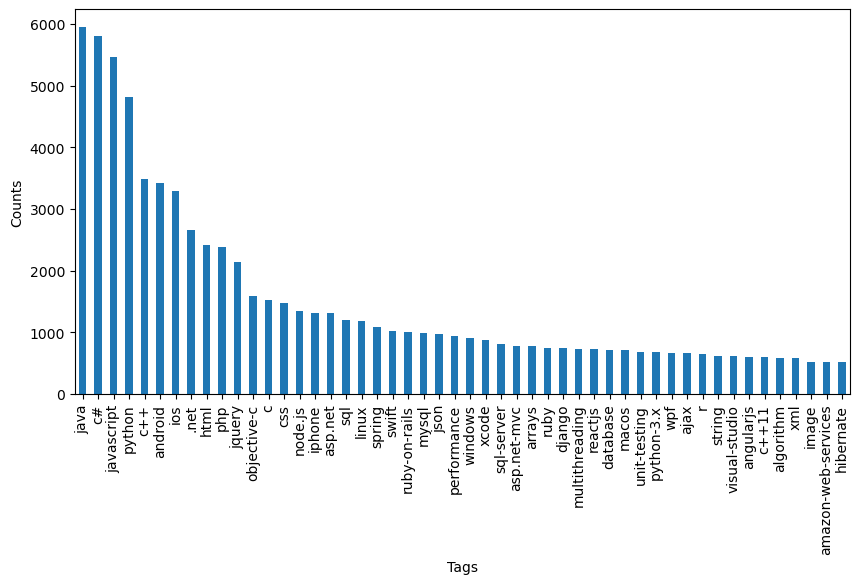

In [13]:
plt.figure(figsize=(10,5))
vc_tags[:50].plot(kind = 'bar')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

Les tags qui reviennent le plus sont des langages de programmation Java, C#, JavaScript et Python.

In [14]:
from collections import Counter
# Comptez le nombre d'occurrences de chaque tag
compteur_de_tags = Counter(tags)

# Initialisez une liste pour stocker les tags qui répondent à vos critères
liste_tags_3_carac = []
liste_tags_util = []


# Parcourez le compteur de tags
for tag, count in compteur_de_tags.items():
    if len(tag) < 4 and count > 20:
        liste_tags_3_carac.append(tag)
print(len(set(liste_tags_3_carac)))

# Parcourez le compteur de tags
for tag, count in compteur_de_tags.items():
    if count >= 100:
        liste_tags_util.append(tag)
print(len(set(liste_tags_util)))

141
353


In [15]:
top_300_tags = vc_tags[:200].index.tolist()
top_6_tags = vc_tags[:6].index.tolist()

# Séparation de jeu de données d'entrainement et de test

In [16]:
df = pd.read_parquet('dataset_clean.parquet')

In [17]:
top_300_tags = vc_tags[:200].index.tolist()


top_300_tags

In [18]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,nb_tags,Body_clean_sans_verbe,Title_clean_sans_verbe,body_title_clean_sans_verbe
0,What's a good html e-mail template system that...,<p>We have a web application that periodically...,"[java, html, text, templates, email]",468478,4,2351,5,web application periodically mail user moment ...,good html mail template system also correctly ...,web application periodically mail user moment ...
1,Rows With Different UI Swift and also reusing ...,<p>I am making a layout similar to this <a hre...,"[ios, swift, uitableview, storyboard, xib]",39000110,3,331,5,layout similar cell different approx cell file...,row different swift also cell different view c...,layout similar cell different approx cell file...
2,How can I set the colors per value when colori...,"<p>In matplotlib (in particular, pandas), how ...","[python, pandas, matplotlib, colors, seaborn]",39000115,5,5654,5,matplotlib particular panda specific color val...,color value plot data frame column,matplotlib particular panda specific color val...
3,R: How can I read a CSV file with data.table::...,<p>I got several CSV files which contain numbe...,"[r, data.table, fread, read.csv, readr]",39000131,7,7510,5,several csv file number local german style com...,r csv file data table comma decimal point thou...,several csv file number local german style com...
4,Run bash script with sh,<p>I have bash script and it requires bash.</p...,"[linux, bash, shell, sh, dash-shell]",19538669,18,89968,5,bash script another person sh script name sh s...,bash script sh,bash script another person sh script name sh s...


In [19]:
# Filtrer la colonne Tags
df['tags_v2'] = df['Tags'].apply(lambda tags: [tag for tag in tags if tag in top_300_tags])
df

,Title,Body,Tags,Id,Score,ViewCount,nb_tags,Body_clean_sans_verbe,Title_clean_sans_verbe,body_title_clean_sans_verbe,tags_v2
0,What's a good html e-mail template system that...,<p>We have a web application that periodically...,"[java, html, text, templates, email]",468478,4,2351,5,web application periodically mail user moment ...,good html mail template system also correctly ...,web application periodically mail user moment ...,"[java, html, templates, email]"
1,Rows With Different UI Swift and also reusing ...,<p>I am making a layout similar to this <a hre...,"[ios, swift, uitableview, storyboard, xib]",39000110,3,331,5,layout similar cell different approx cell file...,row different swift also cell different view c...,layout similar cell different approx cell file...,"[ios, swift, uitableview]"
2,How can I set the colors per value when colori...,"<p>In matplotlib (in particular, pandas), how ...","[python, pandas, matplotlib, colors, seaborn]",39000115,5,5654,5,matplotlib particular panda specific color val...,color value plot data frame column,matplotlib particular panda specific color val...,"[python, pandas, matplotlib]"
3,R: How can I read a CSV file with data.table::...,<p>I got several CSV files which contain numbe...,"[r, data.table, fread, read.csv, readr]",39000131,7,7510,5,several csv file number local german style com...,r csv file data table comma decimal point thou...,several csv file number local german style com...,[r]
4,Run bash script with sh,<p>I have bash script and it requires bash.</p...,"[linux, bash, shell, sh, dash-shell]",19538669,18,89968,5,bash script another person sh script name sh s...,bash script sh,bash script another person sh script name sh s...,"[linux, bash, shell]"
...,...,...,...,...,...,...,...,...,...,...,...
49995,How to compile *.po gettext translations in se...,<p>Consider a python package that has multilan...,"[python, gettext, distutils, setup.py, po]",34070103,4,2435,5,python package multi language support text com...,compile text translation python script,python package multi language support text com...,[python]
49996,ECS Fargate task fails: CannotPullContainerErr...,<p>We have other ECS Services running which us...,"[amazon-web-services, docker, amazon-ecs, aws-...",69130737,6,11301,5,service image private repo however service pul...,gate task cannot pull container error inspect ...,service image private repo however service pul...,"[amazon-web-services, docker]"
49997,Setting up a Deb Package for a Python Project ...,<p>I am trying to make a .deb package out of a...,"[python, qt, sqlite, package, debian]",17992240,3,319,5,make package python project program need file ...,package python project database lite setup,make package python project program need file ...,"[python, qt, sqlite]"
49998,Chrome and Firefox caching a 403,<p>I've got a weird bug and wondered if anyone...,"[http, google-chrome, firefox, browser-cache, ...",17992360,9,4612,5,weird anyone else cause scenario user access c...,chrome firefox,weird anyone else cause scenario user access c...,"[http, google-chrome, firefox]"


In [20]:
lignes_avec_liste_vide = df[df['tags_v2'].apply(lambda x: len(x) == 0)]
lignes_avec_liste_vide.shape

(1755, 11)

Il y a 1178 lignes qui n'ont pas au moins l'un des 300 tops tags, nous allons donc supprimer ces lignes

In [21]:
df = df[df['tags_v2'].apply(lambda x: len(x) > 0)]
df.shape

(48245, 11)

In [22]:
df = df.reset_index()

In [23]:
df.drop(columns='index', inplace=True)

In [24]:
df.shape

(48245, 11)

In [25]:
top_5_tags = vc_tags[:5].index.tolist()

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Créer une instance de MultiLabelBinarizer avec les top 50 tags
mlb = MultiLabelBinarizer(classes=top_5_tags)

# Binariser les tags et obtenir un DataFrame des étiquettes binaires
binary_labels_df = pd.DataFrame(mlb.fit_transform(df['tags_v2']), columns=mlb.classes_)
binary_labels_df.shape

c:\Users\doare\anaconda3new\envs\NLP\Lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['.net', '.net-core', 'ajax', 'algorithm', 'amazon-s3', 'amazon-web-services', 'android', 'android-layout', 'android-studio', 'angular', 'angularjs', 'animation', 'apache', 'apache-spark', 'api', 'arrays', 'asp.net', 'asp.net-core', 'asp.net-mvc', 'asp.net-mvc-4', 'asp.net-web-api', 'assembly', 'asynchronous', 'audio', 'authentication', 'azure', 'bash', 'boost', 'browser', 'build', 'c', 'c++11', 'caching', 'class', 'cocoa', 'cocoa-touch', 'concurrency', 'cordova', 'css', 'data-structures', 'database', 'dataframe', 'date', 'datetime', 'debugging', 'delphi', 'dependency-injection', 'design-patterns', 'dictionary', 'django', 'docker', 'dom', 'eclipse', 'email', 'encryption', 'entity-framework', 'events', 'excel', 'exception', 'express', 'facebook', 'file', 'firebase', 'firefox', 'flask', 'flutter', 'forms', 'function', 'gcc', 'generics', 'git', 'google-chrome', 'googl

(48245, 5)

In [27]:
# Concaténer les nouvelles colonnes binaires avec le DataFrame original
df_test = pd.concat([df, binary_labels_df], axis=1)
df_test.shape

(48245, 16)

In [28]:
X_title = df['Title_clean_sans_verbe']
X_body = df['Body_clean_sans_verbe']
y = df['tags_v2']

In [29]:
#Title
X_title_train, X_title_test, y_title_train, y_title_test = train_test_split(df_test['Title_clean_sans_verbe'], df_test['tags_v2'], test_size=0.2, random_state=42, stratify=df_test.iloc[:, -5:]) #, stratify=y

#body_title_clean_sans_verbe
X_body_train, X_body_test, y_body_train, y_body_test = train_test_split(df_test['body_title_clean_sans_verbe'], df_test['tags_v2'], test_size=0.2, random_state=42, stratify=df_test.iloc[:, -5:]) #, stratify=y

# Méthode bag of words - TF/IDF

In [30]:
#Title
title_tfidf_vector = TfidfVectorizer()
title_tfidf_train = title_tfidf_vector.fit_transform(X_title_train)
title_tfidf_test = title_tfidf_vector.transform(X_title_test)

#Body
body_tfidf_vector = TfidfVectorizer()
body_tfidf_train = body_tfidf_vector.fit_transform(X_body_train)
body_tfidf_test = body_tfidf_vector.transform(X_body_test)


# Méthode de Word Embedding

#### USE

In [31]:
import tensorflow_hub as hub
import tensorflow as tf

c:\Users\doare\anaconda3new\envs\NLP\Lib\site-packages\tensorflow\python\framework\dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [32]:
# Charger le modèle USE à partir de TensorFlow Hub
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(use_url)

# Obtenir les embeddings pour les titres du train set
title_embeddings_train = embed(X_body_train)

# Obtenir les embeddings pour les titres du test set
title_embeddings_test = embed(X_body_test)

#### Word2VEC

In [33]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenisation des phrases
X_body_train_tokenize = [word_tokenize(sentence) for sentence in X_body_train]

# Entraînement du modèle Word2Vec
model_word2vec = Word2Vec(sentences=X_body_train_tokenize, vector_size=100, window=5, min_count=1, sg=0)


In [34]:
def get_sentence_embedding(sentence, word2vec_model):
    words = word_tokenize(sentence)
    valid_words = [word for word in words if word in word2vec_model.wv]
    if len(valid_words) == 0:
        return np.zeros(word2vec_model.vector_size)
    else:
        word_embeddings = [word2vec_model.wv[word] for word in valid_words]
        sentence_embedding = np.mean(word_embeddings, axis=0)  
        return sentence_embedding

# Obtenez les embeddings des phrases en utilisant le modèle Word2Vec
embeddings_train_word2vec = np.array([get_sentence_embedding(sentence, model_word2vec) for sentence in X_body_train])
#embeddings_test_word2vec = np.array([get_sentence_embedding(sentence, model_word2vec) for sentence in sentences_test])


#### BERT

In [35]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

c:\Users\doare\anaconda3new\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# Supposons que votre série de données soit stockée dans la variable 'data'
sentences = X_body_train.tolist()  
sentences_test = X_body_test.tolist()  

# Obtenez les embeddings des phrases
embeddings_train_bert = model.encode(sentences, convert_to_tensor=True)

embeddings_test_bert = model.encode(sentences_test, convert_to_tensor=True)

In [37]:
embeddings_train_bert.shape

torch.Size([38596, 384])

# Modèle Supervisé

### SGD Classifier

In [38]:
#Fonction d'évaluation
def calculer_scores_jaccard(liste_tags_reels, liste_tags_predits):
    # Créez une liste vide pour stocker les scores de Jaccard
    scores_jaccard = []
    scores_precision = []
    tags_reels = []
    tags_predits = []

    # Boucle for pour itérer sur chaque élément de votre jeu de données
    for i in range(len(liste_tags_reels)):
        # Récupérez les ensembles de l'élément i
        ensemble1 = set(liste_tags_reels.iloc[i])
        ensemble2 = set(liste_tags_predits[i])
    
        # Calcul du score de Jaccard pour l'élément i
        intersection = len(ensemble1.intersection(ensemble2))
        union = len(ensemble1) + len(ensemble2) - intersection
    
        # Vérifiez si l'union est égale à zéro pour éviter la division par zéro
        if union != 0:
            score_jaccard = float(intersection) / union*100
        else:
            score_jaccard = 0.0

        # Calcul du score de précision pour l'élément i
        intersection = len(ensemble1.intersection(ensemble2))
        precision = 0
        if len(ensemble2) > 0:
            precision = (intersection / len(ensemble2)) * 100
        else:
            precision = 0.0
    
        # Ajoutez le score de Jaccard, les tags réels et les tags prédits aux listes correspondantes
        scores_jaccard.append(score_jaccard)
        tags_reels.append(ensemble1)
        tags_predits.append(ensemble2)
        scores_precision.append(precision)

    # Créez un DataFrame à partir des listes de tags réels, tags prédits et scores de Jaccard
    resultat_use_train = pd.DataFrame({'Tags Réels': tags_reels, 'Tags Prédits': tags_predits, 'Score Jaccard': scores_jaccard, 'Score de précision': scores_precision})

    # Calculez la moyenne des scores de Jaccard
    moyenne_jaccard_train = sum(scores_jaccard) / len(scores_jaccard)

    # Calculez la moyenne des scores de Jaccard
    moyenne_precision = sum(scores_precision) / len(scores_precision)

    # Affichez la moyenne des scores de Jaccard
    print("Moyenne des scores de Jaccard : ", moyenne_jaccard_train)

    # Affichez la moyenne des scores de Jaccard
    print("Moyenne des scores de précision : ", moyenne_precision)

    return resultat_use_train

In [39]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_body_train_bin = mlb.fit_transform(y_body_train)
y_body_test_bin = mlb.transform(y_body_test)

#### SGD avec TFIDF

In [40]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier

# Créez un modèle SGD Classifier avec la régression logistique ('log') comme fonction de perte
sgd_classifier = MultiOutputClassifier(SGDClassifier(loss='log_loss', max_iter=9000, random_state=0))

# Entraînez le modèle sur l'ensemble d'entraînement
sgd_classifier.fit(body_tfidf_train, y_body_train_bin)

# Prédictions sur l'ensemble d'entraînement
predictions_train = sgd_classifier.predict(body_tfidf_train)

# Prédictions sur l'ensemble de test
predictions_test = sgd_classifier.predict(body_tfidf_test)

# Obtenez les probabilités des classes prédites pour l'ensemble d'entraînement
probabilities_train = sgd_classifier.predict_proba(body_tfidf_train)

# Obtenez les probabilités des classes prédites pour l'ensemble de test
probabilities_test = sgd_classifier.predict_proba(body_tfidf_test)

# Obtenir les tags prédits à partir des vecteurs binarisés
predicted_tags_train = mlb.inverse_transform(predictions_train)
predicted_tags_test = mlb.inverse_transform(predictions_test)

In [41]:
# Obtenez les probabilités prédites pour chaque classe pour l'ensemble d'entraînement
probabilities_train_tfidf = sgd_classifier.predict_proba(body_tfidf_train)

# Obtenez les probabilités prédites pour chaque classe pour l'ensemble de test
probabilities_test_tfidf = sgd_classifier.predict_proba(body_tfidf_test)

In [42]:
resultat_tfidf_train = calculer_scores_jaccard(y_body_train, predicted_tags_train)

Moyenne des scores de Jaccard :  16.085425827497467
Moyenne des scores de précision :  30.336217915500715


In [43]:
resultat_tfidf_test = calculer_scores_jaccard(y_body_test, predicted_tags_test)

Moyenne des scores de Jaccard :  15.918624678599791
Moyenne des scores de précision :  30.1613293260096


In [44]:
probabilities_train_tfidf[0].shape

(38596, 2)

In [82]:
def preditc_proba_seuil(predict_proba_liste, nb_classes, seuil_proba, seuil_min, classes_correspondance): 
    
    """
    Renseigner la variable issu du predict_proba, le seuil de probabilité d'appartenance à une classe 
    ainsi que la variable issu du mlb.classes_
    
    """
    # Création dataset vide qui va comporter toutes nos probas avec en ligne toutes nos observations et colonne nos classes
    df_probabilite = pd.DataFrame()

    # Boucle pour remplir le dataframe df_probabilities
    for i in range(nb_classes):
        # Accéder au bon élémenet issu de predict_proba (récupérer la proba d'appartenance à la classe)
        probabilite_i = predict_proba_liste[i][:, 1]
        df_probabilite[f"classe_{i}"] = probabilite_i
    
    df_probabilite = df_probabilite.set_axis(classes_correspondance, axis=1)

    # Créer un masque TRUE/FALSE avec le seuil de proba choisi
    df_mask = df_probabilite.apply(lambda x: x >= seuil_proba)
    
    # Comptez le nombre de True pour chaque ligne afin de savoir combien de proba sont supérieurs au seuil choisi et donc combien de classe possède l'observation
    nombre_true = df_mask.sum(axis=1)

    # Enregistrez cela dans un nouveau dataframe
    df_nb_true = pd.DataFrame({"nb_true": nombre_true})

    # Ajoutez une colonne pour la classe la plus probable 
    df_nb_true["nom_classe"] = df_probabilite.idxmax(axis=1)
    df_nb_true["proba_classe_max"] = df_probabilite.max(axis=1)
    
    def get_top_class(row):
        if row["nb_true"] == 0:
            # Aucune classe n'a une probabilité supérieure au seuil, on prend la classe avec la probabilité maximale
            max_proba_class = df_probabilite.loc[row.name].idxmax()
            max_proba_value = df_probabilite.loc[row.name].max()
            if max_proba_value >= seuil_min:
                return max_proba_class
            else:
                return "Pas de tags"  # Aucune classe ne dépasse le seuil minimum
        else:
            # Retourner toutes les classes avec une probabilité supérieure à 0.5
            classes_sup_05 = df_probabilite.columns[df_probabilite.loc[row.name] >= 0.5].tolist()
            return classes_sup_05

    df_nb_true["classe_predite"] = df_nb_true.apply(get_top_class, axis=1)
    
    return df_nb_true

In [83]:
predict_proba_liste = probabilities_train_tfidf
nb_classes = 200
seuil_proba = 0.5
seuil_min = 0.1
classes_correspondance = mlb.classes_

romain = preditc_proba_seuil(predict_proba_liste, nb_classes, seuil_proba, seuil_min, classes_correspondance)
romain

C:\Users\doare\AppData\Local\Temp\ipykernel_6984\3435321872.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_probabilite[f"classe_{i}"] = probabilite_i
C:\Users\doare\AppData\Local\Temp\ipykernel_6984\3435321872.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_probabilite[f"classe_{i}"] = probabilite_i
C:\Users\doare\AppData\Local\Temp\ipykernel_6984\3435321872.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

,nb_true,nom_classe,proba_classe_max,classe_predite
0,1,arrays,0.891865,[arrays]
1,1,javascript,0.537940,[javascript]
2,1,java,0.995966,[java]
3,0,exception,0.415166,exception
4,1,c#,0.826543,[c#]
...,...,...,...,...
38591,0,android,0.209231,android
38592,1,angularjs,0.641191,[angularjs]
38593,1,ruby,0.674829,[ruby]
38594,1,javascript,0.690478,[javascript]


In [85]:
resultat_tfidf_train = calculer_scores_jaccard(y_body_train, romain['classe_predite'])

Moyenne des scores de Jaccard :  16.880479506323134
Moyenne des scores de précision :  31.599422466675524


#### SGD USE

In [51]:
# Créez un modèle SGD Classifier avec la régression logistique ('log') comme fonction de perte
sgd_classifier = MultiOutputClassifier(SGDClassifier(loss='log_loss', max_iter=1000, random_state=0))

# Entraînez le modèle sur l'ensemble d'entraînement
sgd_classifier.fit(title_embeddings_train, y_body_train_bin)

# Prédictions sur l'ensemble d'entraînement
predictions_train = sgd_classifier.predict(title_embeddings_train)

# Prédictions sur l'ensemble de test
predictions_test = sgd_classifier.predict(title_embeddings_test)

# Obtenir les tags prédits à partir des vecteurs binarisés
predicted_tags_train = mlb.inverse_transform(predictions_train)
predicted_tags_test = mlb.inverse_transform(predictions_test)

In [52]:
resultat_use_train = calculer_scores_jaccard(y_body_train, predicted_tags_train)

Moyenne des scores de Jaccard :  20.536713649083584
Moyenne des scores de précision :  38.71463364079183


In [53]:
resultat_use_test = calculer_scores_jaccard(y_body_test, predicted_tags_test)

Moyenne des scores de Jaccard :  20.122465195011706
Moyenne des scores de précision :  38.05368431961862


In [54]:
test_use = resultat_use_train[resultat_use_train['Score de précision']>0]
test_use.describe()

,Score Jaccard,Score de précision
count,15878.000000,15878.000000
mean,49.920330,94.106940
std,24.644231,16.053386
min,14.285714,20.000000
25%,33.333333,100.000000
50%,50.000000,100.000000
75%,50.000000,100.000000
max,100.000000,100.000000


In [55]:
resultat_use_test = calculer_scores_jaccard(y_title_test, predicted_tags_test)

Moyenne des scores de Jaccard :  20.122465195011706
Moyenne des scores de précision :  38.05368431961862


### SGD Classifier avec Bert

In [56]:
sgd_classifier = MultiOutputClassifier(SGDClassifier(loss='log_loss', max_iter=1000, random_state=0))

# Entraînez le modèle sur l'ensemble d'entraînement
sgd_classifier.fit(embeddings_train_bert, y_body_train_bin)

# Prédictions sur l'ensemble d'entraînement
predictions_train = sgd_classifier.predict(embeddings_train_bert)

# Prédictions sur l'ensemble de test
predictions_test = sgd_classifier.predict(embeddings_test_bert)

# Obtenir les tags prédits à partir des vecteurs binarisés
predicted_tags_train = mlb.inverse_transform(predictions_train)
predicted_tags_test = mlb.inverse_transform(predictions_test)

In [57]:
# Obtenez les probabilités prédites pour chaque classe pour l'ensemble d'entraînement
probabilities_train = sgd_classifier.predict_proba(embeddings_train_bert)

# Obtenez les probabilités prédites pour chaque classe pour l'ensemble de test
probabilities_test = sgd_classifier.predict_proba(embeddings_test_bert)

In [58]:
probabilities_train

[array([[0.98985344, 0.01014656],
        [0.97884753, 0.02115247],
        [0.97567937, 0.02432063],
        ...,
        [0.9979517 , 0.0020483 ],
        [0.97266418, 0.02733582],
        [0.99476554, 0.00523446]]),
 array([[9.98395366e-01, 1.60463359e-03],
        [9.97267665e-01, 2.73233471e-03],
        [9.98119637e-01, 1.88036272e-03],
        ...,
        [9.97015143e-01, 2.98485654e-03],
        [9.99064948e-01, 9.35052029e-04],
        [9.92436643e-01, 7.56335697e-03]]),
 array([[9.89591498e-01, 1.04085016e-02],
        [9.67593455e-01, 3.24065451e-02],
        [9.91579537e-01, 8.42046345e-03],
        ...,
        [9.99263273e-01, 7.36727435e-04],
        [9.87606615e-01, 1.23933851e-02],
        [9.99707367e-01, 2.92632860e-04]]),
 array([[9.97703679e-01, 2.29632116e-03],
        [9.96256567e-01, 3.74343277e-03],
        [9.97043711e-01, 2.95628901e-03],
        ...,
        [9.98937348e-01, 1.06265241e-03],
        [9.96024096e-01, 3.97590408e-03],
        [9.99627534e-01,

In [59]:
test =  embeddings_train_bert[0].reshape(1, -1)

In [60]:
test.shape

torch.Size([1, 384])

In [61]:
# Prédictions sur l'ensemble d'entraînement
proba_train = sgd_classifier.predict_proba(test)

predict_train = sgd_classifier.predict(test)

In [62]:
resultat_xgb_train = calculer_scores_jaccard(y_body_train, predicted_tags_train)

Moyenne des scores de Jaccard :  25.583498660113992
Moyenne des scores de précision :  45.56607765917037


In [63]:
resultat_xgb_test = calculer_scores_jaccard(y_body_test, predicted_tags_test)

Moyenne des scores de Jaccard :  25.169250206041852
Moyenne des scores de précision :  45.204684423256325


In [64]:
predicted_tags_test

[('mysql',),
 ('c++',),
 (),
 ('ios', 'swift'),
 (),
 ('sql',),
 (),
 (),
 ('java', 'spring'),
 ('javascript',),
 ('android',),
 ('android', 'java'),
 ('c', 'c++', 'gcc'),
 ('javascript',),
 ('android',),
 ('c++',),
 ('c#',),
 ('sql',),
 (),
 ('python',),
 (),
 ('c', 'c++'),
 (),
 ('json', 'python'),
 ('hibernate', 'java'),
 ('c#',),
 (),
 (),
 (),
 ('java',),
 ('css', 'html', 'javascript'),
 (),
 (),
 (),
 (),
 ('ios',),
 (),
 ('javascript',),
 (),
 ('android',),
 ('html',),
 ('java',),
 (),
 (),
 (),
 ('wpf',),
 ('c++',),
 ('c++',),
 ('ruby', 'ruby-on-rails'),
 ('ajax', 'javascript', 'jquery', 'json'),
 ('java',),
 (),
 ('python', 'qt'),
 ('css',),
 (),
 ('css', 'html'),
 (),
 ('flutter',),
 ('c++',),
 (),
 ('css', 'html', 'javascript'),
 ('php',),
 (),
 (),
 ('angularjs', 'javascript'),
 ('java', 'spring'),
 ('css', 'html'),
 (),
 ('c#', 'wpf'),
 ('c++',),
 ('java',),
 (),
 ('assembly',),
 ('android',),
 ('android',),
 ('multithreading',),
 (),
 (),
 (),
 ('java',),
 (),
 ('javascri

In [194]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer

# Créez un modèle SVM Classifier avec la régression logistique ('log') comme fonction de perte
svm_classifier = MultiOutputClassifier(SVC(kernel='linear', probability=True, random_state=0))

# Entraînez le modèle sur l'ensemble d'entraînement
svm_classifier.fit(embeddings_train_bert, y_body_train_bin)

# Prédictions sur l'ensemble d'entraînement
predictions_train = svm_classifier.predict(embeddings_train_bert)

# Prédictions sur l'ensemble de test
predictions_test = svm_classifier.predict(embeddings_test_bert)

# Obtenir les tags prédits à partir des vecteurs binarisés
predicted_tags_train = mlb.inverse_transform(predictions_train)
predicted_tags_test = mlb.inverse_transform(predictions_test)

resultat_xgb_train = calculer_scores_jaccard(y_body_train, predicted_tags_train)


Moyenne des scores de Jaccard :  36.670571586495235
Moyenne des scores de précision :  59.03996959961341


In [202]:
import pickle

# Enregistrez le modèle dans un fichier pickle
with open('svm_classifier_model.pkl', 'wb') as model_file:
    pickle.dump(svm_classifier, model_file)

In [87]:
import pickle


In [88]:
# Charger le modèle depuis le fichier pickle
with open('svm_classifier_model.pkl', 'rb') as model_file:
    loaded_svm_classifier = pickle.load(model_file)

In [90]:
# Prédictions sur l'ensemble d'entraînement
predictions_train = loaded_svm_classifier.predict(embeddings_train_bert)

# Prédictions sur l'ensemble de test
predictions_test = loaded_svm_classifier.predict(embeddings_test_bert)

# Obtenir les tags prédits à partir des vecteurs binarisés
predicted_tags_train = mlb.inverse_transform(predictions_train)
predicted_tags_test = mlb.inverse_transform(predictions_test)

resultat_xgb_train = calculer_scores_jaccard(y_body_train, predicted_tags_train)

Moyenne des scores de Jaccard :  36.670571586495235
Moyenne des scores de précision :  59.03996959961341


In [93]:
# Obtenez les probabilités prédites pour chaque classe pour l'ensemble d'entraînement
probabilities_train_bert = loaded_svm_classifier.predict_proba(embeddings_train_bert)

In [96]:
# Obtenez les probabilités prédites pour chaque classe pour l'ensemble d'entraînement
probabilities_test_bert = loaded_svm_classifier.predict_proba(embeddings_test_bert)

In [94]:
predict_proba_liste = probabilities_train_bert
nb_classes = 200
seuil_proba = 0.5
seuil_min = 0.1
classes_correspondance = mlb.classes_

romain = preditc_proba_seuil(predict_proba_liste, nb_classes, seuil_proba, seuil_min, classes_correspondance)
romain

C:\Users\doare\AppData\Local\Temp\ipykernel_6984\3435321872.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_probabilite[f"classe_{i}"] = probabilite_i
C:\Users\doare\AppData\Local\Temp\ipykernel_6984\3435321872.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_probabilite[f"classe_{i}"] = probabilite_i
C:\Users\doare\AppData\Local\Temp\ipykernel_6984\3435321872.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

,nb_true,nom_classe,proba_classe_max,classe_predite
0,2,php,0.696214,"[arrays, php]"
1,1,php,0.848782,[php]
2,2,swing,0.855332,"[java, swing]"
3,3,exception,0.958677,"[c#, exception, visual-studio]"
4,2,dependency-injection,0.849283,"[c#, dependency-injection]"
...,...,...,...,...
38591,1,android,0.926930,[android]
38592,2,angularjs,0.951011,"[angularjs, unit-testing]"
38593,2,android,0.900605,"[android, ruby]"
38594,3,jquery,0.888402,"[html, javascript, jquery]"


In [95]:
resultat_xgb_train = calculer_scores_jaccard(y_body_train, romain['classe_predite'])

Moyenne des scores de Jaccard :  41.69910861757109
Moyenne des scores de précision :  63.848706013243834


In [110]:
predict_proba_liste = probabilities_test_bert
nb_classes = 200
seuil_proba = 0.5
seuil_min = 0.1
classes_correspondance = mlb.classes_

romain = preditc_proba_seuil(predict_proba_liste, nb_classes, seuil_proba, seuil_min, classes_correspondance)
romain

C:\Users\doare\AppData\Local\Temp\ipykernel_6984\3435321872.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_probabilite[f"classe_{i}"] = probabilite_i
C:\Users\doare\AppData\Local\Temp\ipykernel_6984\3435321872.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_probabilite[f"classe_{i}"] = probabilite_i
C:\Users\doare\AppData\Local\Temp\ipykernel_6984\3435321872.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

,nb_true,nom_classe,proba_classe_max,classe_predite
0,1,mysql,0.931558,[mysql]
1,2,c++,0.975545,"[boost, c++]"
2,1,sql,0.596509,[sql]
3,2,ios,0.939592,"[ios, swift]"
4,0,ios,0.287253,ios
...,...,...,...,...
9644,1,android,0.914649,[android]
9645,2,sql-server,0.518455,"[c#, sql-server]"
9646,2,sql,0.870927,"[mysql, sql]"
9647,1,django,0.941382,[django]


In [98]:
resultat_xgb_test = calculer_scores_jaccard(y_body_test, romain['classe_predite'])

Moyenne des scores de Jaccard :  37.69684654309996
Moyenne des scores de précision :  59.41871223973008


In [106]:
resultat_xgb_test.tail(30)

,Tags Réels,Tags Prédits,Score Jaccard,Score de précision
9619,"{c#, xaml, wpf, .net}","{#, c}",0.000000,0.000000
9620,{git},{git},100.000000,100.000000
9621,"{qt, c++, data-structures}",{c},0.000000,0.000000
9622,"{exception, c++}",{c++},50.000000,100.000000
9623,"{c++11, c++}",{c++},50.000000,100.000000
9624,"{rest, javascript}",{javascript},50.000000,100.000000
9625,"{dataframe, python, pandas, dictionary}","{dataframe, python, pandas}",75.000000,100.000000
9626,"{apache, wordpress}","{ubuntu, wordpress, php}",25.000000,33.333333
9627,"{jquery, css, javascript}","{jquery, css, javascript}",100.000000,100.000000
9628,"{date, ruby-on-rails, ruby}","{datetime, ruby}",25.000000,50.000000


In [195]:
resultat_xgb_test = calculer_scores_jaccard(y_body_test, predicted_tags_test)

Moyenne des scores de Jaccard :  33.59114440677296
Moyenne des scores de précision :  55.49763360624598


#### TSNE 

In [107]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire les dimensions à 2
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_test_bert)


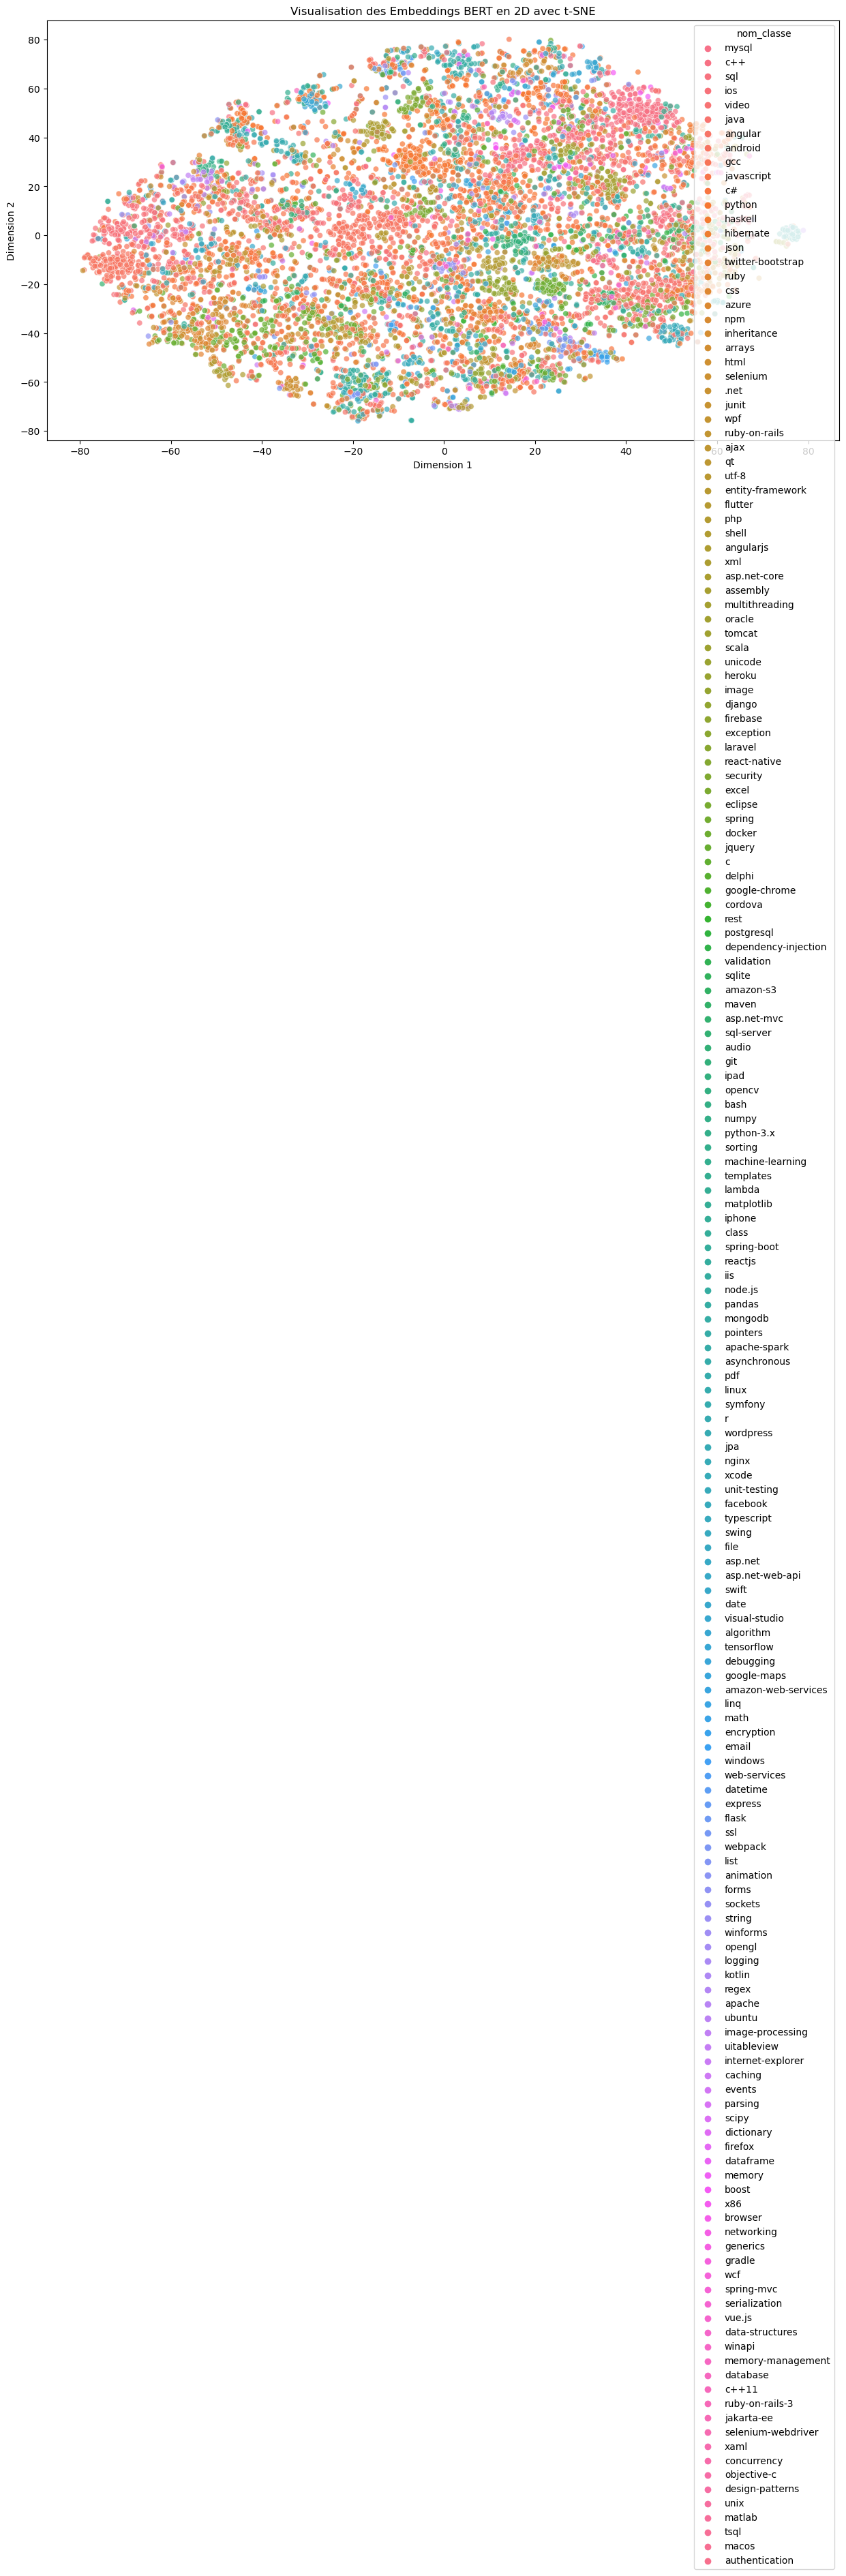

In [116]:
# Visualiser les embeddings en 2D
plt.figure(figsize=(15, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=romain['nom_classe'], alpha=0.7)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Visualisation des Embeddings BERT en 2D avec t-SNE')
plt.show()

 ### Notebook simulation
 1 - Méthode non supervisé
 <br>a - LDA (pour visualisation LDAvis)

<br>2 - Méthode supervisé (Logistic, SGDClassifier)
<br>a - Classique : TD/IDF, bag_of_words
<br>b - Sentence Embedding : BERT, USE, Glove